# Spatial Transformer Networks Test

## Setup

In [975]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from __future__ import print_function, division

import os
import sys

# NOTE: Inferring the project root path like this will not always work
# (e.g. when the notebook resides on a different server to the kernel)
# Set the path directly if necessary.
root_path = os.path.dirname(os.getcwd())

sys.path.append(root_path)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import time
import copy
import glob
import re
import importlib
from PIL import Image

from imednet.data.smnist_loader import MatLoader, Mapping
from imednet.trainers.encoder_decoder_trainer import Trainer
from imednet.data.nmnist_loader import NMNIST
from imednet.models.encoder_decoder import CNNEncoderDecoderNet

plt.ion()   # interactive mode

## Loading the data

Here we use the same data loaders as used in the [PyTorch Spatial Transformer Network Tutorial](https://pytorch.org/tutorials/intermediate/spatial_transformer_tutorial.html) that takes the classic MNIST dataset and uses it to train a standard convolutional network augmented with a spatial transformer network.

In [976]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root=os.path.join(root_path, 'data/mnist'), train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=64, shuffle=True, num_workers=4)
# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root=os.path.join(root_path, 'data/mnist'), train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)

## Depicting spatial transformer networks

(from the [PyTorch Spatial Transformer Network Tutorial](https://pytorch.org/tutorials/intermediate/spatial_transformer_tutorial.html))

Spatial transformer networks boils down to three main components:

* The localization network is a regular CNN which regresses the transformation parameters. The transformation is never learned explicitly from this dataset, instead the network learns automatically the spatial transformations that enhances the global accuracy.
* The grid generator generates a grid of coordinates in the input image corresponding to each pixel from the output image.
* The sampler uses the parameters of the transformation and applies it to the input image.

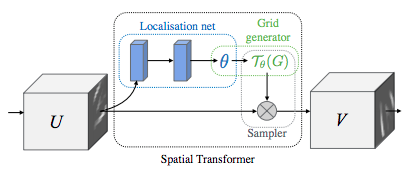

Note: We need the latest version of PyTorch that contains the `affine_grid` and `grid_sample` modules.

In [977]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


model = Net().to(device)

## Training the model

(from the [PyTorch Spatial Transformer Network Tutorial](https://pytorch.org/tutorials/intermediate/spatial_transformer_tutorial.html))

Now, let's use the SGD algorithm to train the model. The network is learning the classification task in a supervised way. In the same time the model is learning STN automatically in an end-to-end fashion.

In [978]:
optimizer = optim.SGD(model.parameters(), lr=0.01)


def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
#
# A simple test procedure to measure STN the performances on MNIST.
#


def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

## Visualizing the STN results

(from the [PyTorch Spatial Transformer Network Tutorial](https://pytorch.org/tutorials/intermediate/spatial_transformer_tutorial.html))

Now, we will inspect the results of our learned visual attention mechanism.

We define a small helper function in order to visualize the transformations while training.

In [980]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')


for epoch in range(1, 20 + 1):
    train(epoch)
    test()

# Visualize the STN transformation on some input batch
visualize_stn()

plt.ioff()
plt.show()

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.479362
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.409406

Test set: Average loss: 0.1349, Accuracy: 9602/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.183512
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.289091

Test set: Average loss: 0.0983, Accuracy: 9715/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.377493
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.406021

Test set: Average loss: 0.0867, Accuracy: 9741/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.230754
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.209022

Test set: Average loss: 0.0826, Accuracy: 9748/10000 (97%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.272095
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.159170

Test set: Average loss: 0.1038, Accuracy: 9689/10000 (97%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.345438
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.145717

Test set: Average loss: 0.0600, Accuracy: 9818/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.046317
Train Epoch: 7 [320

Process Process-320:
Process Process-319:
Process Process-317:
Process Process-318:


KeyboardInterrupt: 

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home0/barry.ridge/anaconda3/envs/py3.6_tf1.8.0_cuda9.2/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home0/barry.ridge/anaconda3/envs/py3.6_tf1.8.0_cuda9.2/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home0/barry.ridge/anaconda3/envs/py3.6_tf1.8.0_cuda9.2/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home0/barry.ridge/anaconda3/envs/py3.6_tf1.8.0_cuda9.2/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home0/barry.ridge/anaconda3/envs/py3.6_tf1.8.0_cuda9.2/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home0/barry.ridge/anaconda3/envs/py3.6_tf1.8.0_cuda9.2/lib/python3.6/multiprocessing/process.py", 

## Test on s-MNIST Data

In [981]:
data_path = os.path.join(root_path, 'data/s-mnist/40x40-smnist-seed-42.mat')
images, outputs, scale, original_trj = MatLoader.load_data(data_path)

# digit = 9
# indices = np.asarray(range(0,len(images)))
# test_sample_indices = indices[digit:-1:10]
test_sample_indices = range(1,10)

torch_images = torch.autograd.Variable(torch.from_numpy(images[test_sample_indices, :])).float()
torch_outputs = torch.autograd.Variable(torch.from_numpy(outputs[test_sample_indices, :])).float()

In [982]:
outputs.shape

(3000, 55)

In [983]:
torch_images.reshape(9,1,40,40).shape

torch.Size([9, 1, 40, 40])

In [984]:
def visualize_smnist_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = torch_images.reshape(9,1,40,40).to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

In [985]:
data = torch_images.reshape(9,1,40,40).to(device)


In [986]:
xs = model.localization(data)
xs = xs.view(-1, 10 * 3 * 3)
theta = model.fc_loc(xs)
theta = theta.view(-1, 2, 3)

theta.shape
# grid = F.affine_grid(theta, data.size())
# x = F.grid_sample(x, grid)

torch.Size([36, 2, 3])

In [987]:
theta.shape

torch.Size([36, 2, 3])

In [988]:
data.size()

torch.Size([9, 1, 40, 40])

In [989]:
torch_outputs.shape

torch.Size([9, 55])

In [990]:
def load_model(root_path, model_path):
    # Read network description file
    with open(os.path.join(root_path, model_path, 'network_description.txt')) as f:
        network_description_str = f.read()

    # Get the model class from the network description and dynamically import it
    model_module_class_str = re.search('Model: (.+?)\n', network_description_str).group(1)
    model_module_str = os.path.splitext(model_module_class_str)[0]
    model_class_str = os.path.splitext(model_module_class_str)[1][1:]
    model_module = importlib.import_module(model_module_str)
    model_class = getattr(model_module, model_class_str)

    # Get the pre-trained CNN model load path from the network description
    if model_class_str == 'CNNEncoderDecoderNet':
        pre_trained_cnn_model_path = os.path.join(root_path, re.search('Pre-trained CNN model load path: (.+?)\n', network_description_str).group(1))
    elif model_class_str == 'STIMEDNet' or model_class_str == 'FullSTIMEDNet':
        pre_trained_imednet_model_path = os.path.join(root_path, re.search('Pre-trained IMEDNet model load path: (.+?)\n', network_description_str).group(1))
        
    # Load layer sizes
    layer_sizes = np.load(os.path.join(root_path, model_path, 'layer_sizes.npy')).tolist()

    # Load scaling
    try:
        scaling = Mapping()
        scaling.x_max = np.load(os.path.join(root_path, model_path, 'scale_x_max.npy'))
        scaling.x_min = np.load(os.path.join(root_path, model_path, 'scale_x_min.npy'))
        scaling.y_max = np.float(np.load(os.path.join(root_path, model_path, 'scale_y_max.npy')))
        scaling.y_min = np.float(np.load(os.path.join(root_path, model_path, 'scale_y_min.npy')))
    except:
        scaling = np.load(os.path.join(root_path, model_path, 'scale.npy'))

    # Load the model
    if model_class_str == 'CNNEncoderDecoderNet':
        model = model_class(pre_trained_cnn_model_path, layer_sizes, scaling)
    elif model_class_str == 'STIMEDNet' or model_class_str == 'FullSTIMEDNet':
        model = model_class(pre_trained_imednet_model_path, scale=scaling)
    else:
        model = model_class(layer_sizes, None, scaling)
        
    # Load the model state parameters
    state = torch.load(os.path.join(root_path, model_path, 'net_parameters'))
    model.load_state_dict(state)
    
    return model

In [991]:
model_path = 'models/cnn_encoder_decoder/cfcimednet-40x40-smnist-end-to-end-adam 2018-07-22 17:11:17.144898/'
model = load_model(root_path, model_path)
model_stub = 'cfcimednet_etoe_adam'

In [992]:
trainer = Trainer()

In [993]:
dmp = trainer.create_dmp(torch_outputs[2], model.scale, 0.01, 25, True)

In [994]:
dmp.joint()

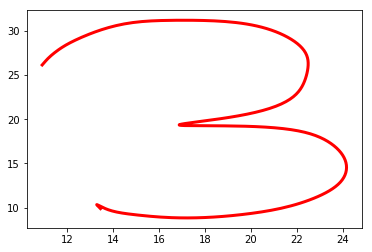

In [995]:
plt.plot(dmp.Y[:,0], dmp.Y[:,1], '-r', linewidth=3.0)

In [996]:
# Define rotation matrix
M = np.array([[0.707, -0.707, 0.], [0.707, 0.707, 0.]])
Full_M = np.array([[0.707, -0.707, 0.], [0.707, 0.707, 0.], [0., 0., 1.0]])

In [997]:
transformed_Y = np.matmul(M, np.hstack([dmp.Y, np.ones([dmp.Y.shape[0],1])]).T).T

In [998]:
M_I = np.linalg.inv(Full_M)
transformed_Y = np.matmul(Full_M, np.hstack([dmp.Y, np.ones([dmp.Y.shape[0],1])]).T).T
inverted_transformed_Y = np.matmul(M_I, transformed_Y.T).T[:,0:2]
transformed_Y = inverted_transformed_Y

In [999]:
traj = np.hstack([transformed_Y, dmp.t[:,0:1]])

In [1000]:
dmps = Trainer.create_dmps([traj], dmp.N, 0.01)

/home0/barry.ridge/Research/Projects/ATR/imednet/imednet/utils/dmp_class.py:135: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.w[:,j] = np.linalg.lstsq(np.transpose(A), ft[:,j])[0]


In [1001]:
transformed_dmp = dmps[0]
transformed_dmp.joint()

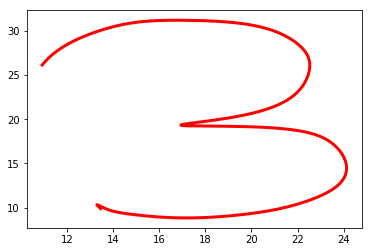

In [1002]:
plt.plot(transformed_dmp.Y[:,0], transformed_dmp.Y[:,1], '-r', linewidth=3.0)

In [1003]:
model.scale
images, outputs, scale, or_tr = MatLoader.load_data(os.path.join(root_path, 'data/s-mnist/40x40-smnist.mat'), load_original_trajectories=True)

In [1004]:
np.float(scale.y_min)

-1.0

In [1005]:
from imednet.utils.dmp_layer import DMPIntegrator, DMPParameters
DMPparam = DMPParameters(25, 3, 0.01, 2, scale)
model.register_buffer('DMPp', DMPparam.data_tensor)
model.register_buffer('scale_t', DMPparam.scale_tensor)
model.register_buffer('param_grad', DMPparam.grad_tensor)
integrator = DMPIntegrator()
output = integrator.apply(torch_outputs, model.DMPp, model.param_grad, model.scale_t)

RuntimeError: The size of tensor a (54) must match the size of tensor b (55) at non-singleton dimension 1

In [1017]:
# model_path = 'models/stimednet/stimednet-40x40-smnist-rotated-images 2018-09-06 11:40:39.271385/'
model_path = 'models/stimednet/stimednet-40x40-smnist-rotated-images-end-to-end 2018-09-06 15:41:13.276921/'
# model_path = 'models/stimednet/fullstimednet-40x40-smnist-rotated-images-end-to-end 2018-09-07 22:14:48.730739/'
model = load_model(root_path, model_path)
model_stub = 'stimednet'

In [1018]:
def show_image_to_motion_prediction(model, trainer, image, output):
    try:
        assert(isinstance(model.image_size, int))
        image_size = model.image_size
    except:
        try:
            image_size = model.imageSize
        except:
            image_size = 40
    
    # Prepare input image
    scaled_image = np.array(image).reshape(1, image_size*image_size)
    scaled_image = scaled_image / np.max(scaled_image)
    torch_scaled_image = torch.autograd.Variable(torch.from_numpy(scaled_image)).float()
    
    # Pass input image to spatial transformer network (STN)
    torch_scaled_image_predicted_stn_output = model.stn(torch_scaled_image.view(-1,1,image_size,image_size))
    # Display STN output image
    stn_fig = plt.figure("STN Output Image")
    plt.imshow(torch_scaled_image_predicted_stn_output.view(image_size,image_size).detach().numpy())
    
    # Do full forward propagation, i.e. model.stn(image) -> model.imednet_model()
    torch_scaled_image_predicted_output = model(torch_scaled_image)
    # Generate DMP from predicted output weights
    torch_scaled_image_predicted_output = torch.cat((torch.tensor([-1.]), torch_scaled_image_predicted_output[0,:]), 0)
    scaled_image_predicted_output_dmp = trainer.create_dmp(torch_scaled_image_predicted_output, model.scale, 0.01, 25, True)
    scaled_image_predicted_output_dmp.joint()
    # Display input image + predicted DMP trajectory in red
    fig = trainer.show_dmp(scaled_image, None, scaled_image_predicted_output_dmp, plot=False)
    
    # Generate DMP from actual output weights
    output_dmp = trainer.create_dmp(torch.from_numpy(output), model.scale, 0.01, 25, True)
    output_dmp.joint()
    # Display the actual output DMP trajectory in green
    plt.plot(output_dmp.Y[:,0], output_dmp.Y[:,1], 'g')
    
    # Pass input image to localizer to get theta transformation parameters
    xs = model.localization(torch_scaled_image.view(-1,1,image_size,image_size))
    xs = xs.view(-1, model.localizer_out_size)
    theta = model.fc_loc(xs)
    theta = theta.view(-1, 2, 3)
    theta = theta.detach().numpy().reshape(2,3)
    # Calculate the inverted transform using theta
    T_theta = np.array([theta[0,:], theta[1,:], [0., 0., 1.0]])
    T_theta_inv = np.linalg.inv(T_theta)
    # Transform the predicted trajectory
    transformed_traj = np.matmul(T_theta_inv, np.hstack([scaled_image_predicted_output_dmp.Y, np.ones([scaled_image_predicted_output_dmp.Y.shape[0],1])]).T).T[:,0:2]
    # Display the transformed predicted trajectory in blue
    plt.plot(transformed_traj[:,0], transformed_traj[:,1], 'b')

In [1019]:
data_path = os.path.join(root_path, 'data/s-mnist/40x40-smnist.mat')
data_stub = '40x40-smnist'
images, outputs, scale, original_trj = MatLoader.load_data(data_path)

In [1020]:
data_path = os.path.join(root_path, 'data/s-mnist/40x40-smnist-rotated.mat')
data_stub = '40x40-smnist-rotated'
# images, outputs, scale, original_trj = MatLoader.load_data(data_path, image_key='trans_imageArray')
images, outputs, scale, or_tr = MatLoader.load_data(data_path,
                                                    image_key='trans_imageArray',
                                                    traj_key='trans_trajArray',
                                                    dmp_params_key='TransDMPParamsArray',
                                                    dmp_traj_key='TransDMPTrajArray',
                                                    load_original_trajectories=True)

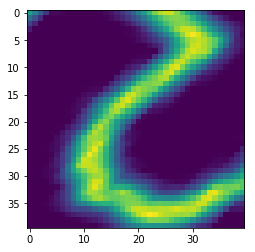

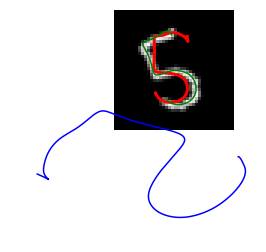

In [1021]:
i_sample = np.random.randint(images.shape[0])
sample_image = images[i_sample,:].reshape(40,40)
sample_output = outputs[i_sample,:]
show_image_to_motion_prediction(model, trainer, sample_image, sample_output)

In [1022]:
outputs[i_sample,:].shape

(55,)

In [1023]:
x = torch_images.view(-1, 1, 40, 40)
xs = model.localization(x)
xs = xs.view(-1, model.localizer_out_size)
theta = model.fc_loc(xs)
theta = theta.view(-1, 2, 3)
theta[0,:,:].shape

torch.Size([2, 3])

In [1024]:
torch.as_tensor([[0.0,0.0,1.0]]).shape
torch.cat((theta[0,:,:], torch.as_tensor([[0.0,0.0,1.0]])), 0)

tensor([[-0.2106,  0.1847,  0.1668],
        [ 0.1803,  0.4463,  0.0369],
        [ 0.0000,  0.0000,  1.0000]], grad_fn=<CatBackward>)

In [1025]:
theta.shape

torch.Size([9, 2, 3])

In [1026]:
torch.as_tensor([[[0.0,0.0,1.0]]]).repeat([theta.shape[0],1,1]).shape

torch.Size([9, 1, 3])

In [1027]:
T = torch.cat((theta, torch.as_tensor([[[0.0,0.0,1.0]]]).repeat([theta.shape[0],1,1])), 1).cuda()

In [1028]:
T_invs = [T_i.inverse() for T_i in torch.functional.unbind(T)]
T_inv = torch.stack(T_invs)
T_inv.shape

torch.Size([9, 3, 3])

In [1029]:
# A = np.random.randn(2,2,2)
A = np.asarray([[[1,2],[3,4]], [[5,6],[7,8]], [[9,10],[11,12]]])
print(A)
print(A.shape)
# B = np.random.randn(2,2)
B = np.asarray([[1,2], [3,4], [5,6]])
print(B)
print(B.shape)
np.einsum('kij,ki->ik', A, B)

[[[ 1  2]
  [ 3  4]]

 [[ 5  6]
  [ 7  8]]

 [[ 9 10]
  [11 12]]]
(3, 2, 2)
[[1 2]
 [3 4]
 [5 6]]
(3, 2)


array([[  3,  33,  95],
       [ 14,  60, 138]])

In [1030]:
print('T_inv.shape: {}'.format(T_inv.shape))
x = torch.rand(18,301)
print(x[:,0])
print(x.view(9,2,301)[:,:,0])
dummy_x_traj_vectors = x.view(9,2,301).transpose(0,1)
print(dummy_x_traj_vectors[:,:,0])
print(dummy_x_traj_vectors.transpose(1,0).view(18,301)[:,0])
print(dummy_x_traj_vectors.reshape(18,301)[:,0])
foo = T_inv.view(3,3,T_inv.shape[0],1).repeat(1,1,1,x.shape[1])
bar = x.view(9,2,301).transpose(0,1)
print('foo.shape: {}'.format(foo.shape))
print('bar.shape: {}'.format(bar.shape))
foobar = torch.cat((bar, torch.ones(1,9,301)), 0).cuda()
print('foobar.shape: {}'.format(foobar.shape))
# torch.einsum('ijkl,ikl->ikl', [foo, foobar]).shape
torch.einsum('kij,ikl->ikl', [T_inv,foobar]).shape
x_traj_vectors = x.view(int(x.shape[0]/2),2,x.shape[1]).transpose(0,1)
x_traj_vectors_with_ones = torch.cat((x_traj_vectors, torch.ones(1,int(x.shape[0]/2),x.shape[1])), 0).cuda()
transformed_x_traj_vectors = torch.einsum('kij,ikl->ikl', [T_inv, x_traj_vectors_with_ones])[0:2,:,:]
print('transformed_x_traj_vectors.shape: {}'.format(transformed_x_traj_vectors.shape))
output1 = transformed_x_traj_vectors.transpose(1,0)
output2 = transformed_x_traj_vectors.transpose(1,0).contiguous()
print('output1.shape: {}'.format(output1.shape))
print('output2.shape: {}'.format(output2.shape))
print('output1: {}'.format(output1[:,:,0]))
print('output2: {}'.format(output2[:,:,0]))
# output = torch.mul(T_inv.view(T_inv.shape[0],3,3,1).repeat(1,1,1,x.shape[1]), x.view(9,2,301).transpose(0,1))

T_inv.shape: torch.Size([9, 3, 3])
tensor([ 0.3996,  0.7696,  0.6792,  0.8026,  0.3791,  0.8017,  0.5857,
         0.6479,  0.9502,  0.8763,  0.7752,  0.2924,  0.7676,  0.6601,
         0.6721,  0.6517,  0.0882,  0.1383])
tensor([[ 0.3996,  0.7696],
        [ 0.6792,  0.8026],
        [ 0.3791,  0.8017],
        [ 0.5857,  0.6479],
        [ 0.9502,  0.8763],
        [ 0.7752,  0.2924],
        [ 0.7676,  0.6601],
        [ 0.6721,  0.6517],
        [ 0.0882,  0.1383]])
tensor([[ 0.3996,  0.6792,  0.3791,  0.5857,  0.9502,  0.7752,  0.7676,
          0.6721,  0.0882],
        [ 0.7696,  0.8026,  0.8017,  0.6479,  0.8763,  0.2924,  0.6601,
          0.6517,  0.1383]])
tensor([ 0.3996,  0.7696,  0.6792,  0.8026,  0.3791,  0.8017,  0.5857,
         0.6479,  0.9502,  0.8763,  0.7752,  0.2924,  0.7676,  0.6601,
         0.6721,  0.6517,  0.0882,  0.1383])
tensor([ 0.3996,  0.6792,  0.3791,  0.5857,  0.9502,  0.7752,  0.7676,
         0.6721,  0.0882,  0.7696,  0.8026,  0.8017,  0.6479,  0.8

In [1031]:
original_traj = []
for i in range(0,images.shape[0]):
    c,c1,c2 = zip(*or_tr[i])
    original_traj.append(c)
    original_traj.append(c1)

In [1032]:
orig_traj = torch.from_numpy(np.asarray(original_traj))
orig_traj.view(3000,2,301)[:,:,0]

tensor([[ 22.5742,  19.4255],
        [ 23.3264,  23.2717],
        [ 18.8124,   8.7995],
        ...,
        [ 24.1845,   6.8559],
        [ 19.0982,  23.0408],
        [ 28.4774,  16.2807]], dtype=torch.float64)

In [1033]:
or_tr[0]

array([[22.57424837, 19.42545798,  1.        ],
       [22.57424253, 19.42543701,  1.        ],
       [22.57420186, 19.42529105,  1.        ],
       [22.57409218, 19.42489741,  1.        ],
       [22.57387996, 19.42413591,  1.        ],
       [22.57353237, 19.42288887,  1.        ],
       [22.57301714, 19.42104112,  1.        ],
       [22.57230265, 19.41847997,  1.        ],
       [22.57135777, 19.41509528,  1.        ],
       [22.57015191, 19.41077939,  1.        ],
       [22.56865487, 19.40542719,  1.        ],
       [22.56683689, 19.39893612,  1.        ],
       [22.56466849, 19.39120619,  1.        ],
       [22.56212049, 19.38213999,  1.        ],
       [22.5591639 , 19.37164271,  1.        ],
       [22.55576983, 19.35962218,  1.        ],
       [22.55190952, 19.34598885,  1.        ],
       [22.54755414, 19.3306559 ,  1.        ],
       [22.54267486, 19.31353914,  1.        ],
       [22.53724267, 19.29455715,  1.        ],
       [22.53122839, 19.27363122,  1.   

In [1035]:
theta.shape

torch.Size([9, 2, 3])

In [1037]:
N, C, H, W = torch_images.view(-1,1,40,40).shape

In [1038]:
theta.new(N,H,W,3).shape

torch.Size([9, 40, 40, 3])

In [1046]:
theta

tensor([[[-0.2106,  0.1847,  0.1668],
         [ 0.1803,  0.4463,  0.0369]],

        [[-0.3270,  0.3204, -0.0733],
         [ 0.3157,  0.3791,  0.0913]],

        [[-0.3078,  0.2921,  0.0165],
         [ 0.2288,  0.4469,  0.0537]],

        [[-0.1931,  0.2319,  0.1241],
         [ 0.3722,  0.4293,  0.1633]],

        [[-0.2980,  0.2827, -0.0133],
         [ 0.2451,  0.4827,  0.0284]],

        [[-0.2162,  0.2850,  0.0356],
         [ 0.3354,  0.3703,  0.1251]],

        [[-0.2656,  0.1535,  0.1291],
         [ 0.2019,  0.4144,  0.0133]],

        [[-0.3588,  0.3694, -0.0555],
         [ 0.3732,  0.3800,  0.0559]],

        [[-0.1839,  0.4157,  0.0907],
         [ 0.3906,  0.3165,  0.0589]]], grad_fn=<ViewBackward>)

In [1047]:
theta.transpose(0,1).contiguous().transpose(1,0)

tensor([[[-0.2106,  0.1847,  0.1668],
         [ 0.1803,  0.4463,  0.0369]],

        [[-0.3270,  0.3204, -0.0733],
         [ 0.3157,  0.3791,  0.0913]],

        [[-0.3078,  0.2921,  0.0165],
         [ 0.2288,  0.4469,  0.0537]],

        [[-0.1931,  0.2319,  0.1241],
         [ 0.3722,  0.4293,  0.1633]],

        [[-0.2980,  0.2827, -0.0133],
         [ 0.2451,  0.4827,  0.0284]],

        [[-0.2162,  0.2850,  0.0356],
         [ 0.3354,  0.3703,  0.1251]],

        [[-0.2656,  0.1535,  0.1291],
         [ 0.2019,  0.4144,  0.0133]],

        [[-0.3588,  0.3694, -0.0555],
         [ 0.3732,  0.3800,  0.0559]],

        [[-0.1839,  0.4157,  0.0907],
         [ 0.3906,  0.3165,  0.0589]]], grad_fn=<TransposeBackward>)

In [1051]:
torch.eye(3,3).repeat(9,1,1).shape

torch.Size([9, 3, 3])

In [1052]:
theta.shape

torch.Size([9, 2, 3])

In [1057]:
torch.eye(3,3).repeat(9,1,1).cuda().shape

torch.Size([9, 3, 3])

In [1077]:
theta[0:1].shape

torch.Size([1, 2, 3])